In [1]:
import sys
sys.path.append('./../')
import src
from src import proyecto_1
from src.utils import utils
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from numpy import savetxt
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier

In [2]:
proyecto_1.main()

./..\src\pipelines\feature_engineering.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)


In [3]:
c5_inputs = utils.load_df('output/fe_df.pkl')

### Ordenamiento del dataframe de manera cronologica (De fecha mas antigua a mas reciente)

In [4]:
c5_inputs = c5_inputs.sort_values(by=['año_creacion','mes'],ascending=True)

In [5]:
c5_inputs.nunique()

dia_semana               7
delegacion_inicio       16
clas_con_f_alarma        4
tipo_entrada             9
mes                     12
label                    2
año_creacion             8
sin_time             76647
cos_time             78322
dtype: int64

In [6]:
c5_inputs.head()

,dia_semana,delegacion_inicio,clas_con_f_alarma,tipo_entrada,mes,label,año_creacion,sin_time,cos_time
372610,Martes,IZTAPALAPA,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.321921,0.946766
372616,Martes,IZTAPALAPA,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.443788,0.896132
372626,Martes,CUAUHTEMOC,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.438110,0.898922
372644,Martes,IZTACALCO,EMERGENCIA,CÁMARA,1,0,2013,-0.241710,0.970348
372652,Martes,XOCHIMILCO,EMERGENCIA,LLAMADA DEL 066,1,0,2013,-0.678213,0.734865


### Definimos los nombres de las variables que vamos a usar

In [7]:
names=np.array(c5_inputs.dia_semana.unique())
names=np.append(names,np.array(c5_inputs.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_inputs.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_inputs.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))

### Definimos los transformadores de las variables categoricas y la imputacion de datos con la media de coseno y seno del tiempo

In [8]:
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
               ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
               ('mes', SimpleImputer(strategy="mean"), ['mes']),
               ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
               ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]

In [9]:
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
#col_trans = ColumnTransformer(transformers, n_jobs=-1, verbose=True)

In [10]:
col_trans.fit(c5_inputs)

ColumnTransformer(n_jobs=-1,
                  transformers=[('one_hot', OneHotEncoder(),
                                 ['dia_semana', 'delegacion_inicio',
                                  'clas_con_f_alarma', 'tipo_entrada']),
                                ('año', SimpleImputer(), ['año_creacion']),
                                ('mes', SimpleImputer(), ['mes']),
                                ('impute_sin_time',
                                 SimpleImputer(strategy='median'),
                                 ['sin_time']),
                                ('impute_cos_time',
                                 SimpleImputer(strategy='median'),
                                 ['cos_time'])],
                  verbose=True)

In [11]:
c5_input_vars = col_trans.transform(c5_inputs)

In [12]:
c5_input_vars.shape

(1382537, 40)

### Definimos la matriz de las variables para la prediccion y la etiqueta que queremos predecir

In [13]:
X = c5_input_vars
y = c5_inputs.label.values.reshape(c5_input_vars.shape[0],)

### Aplicamos Grid Search para comparar distintos modelos

In [14]:
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [10,20], 
                    'max_depth': [1, 2, 5],
                    'min_samples_split': [2, 4]}

#Time Series cross-validator
tscv = TimeSeriesSplit(n_splits=8)

# ocupemos grid search!
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision',
                           cv = tscv,
                            
                           n_jobs = -1)
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  126.81489825248718


C:\Users\diego172\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\diego172\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [15]:
gs.cv_results_

{'mean_fit_time': array([ 5.72581816, 10.99703783,  5.93049935, 11.36237344,  7.59294406,
        14.77605516,  7.66476271, 13.9409686 , 13.76878917, 25.27077675,
        13.45017898, 17.49003085]),
 'std_fit_time': array([ 3.08795971,  6.19739259,  3.15971203,  5.84513037,  4.02793909,
         7.86912744,  4.19078146,  7.79181041,  7.66902139, 13.05536992,
         7.25981644,  6.32797113]),
 'mean_score_time': array([0.26818338, 0.42112455, 0.28217411, 0.42300999, 0.28319395,
        0.45112866, 0.2712383 , 0.4108527 , 0.27538985, 0.43276259,
        0.26378855, 0.29296055]),
 'std_score_time': array([0.02807613, 0.04967294, 0.03234924, 0.03100486, 0.03960867,
        0.04818639, 0.01715537, 0.0152148 , 0.02090779, 0.10256445,
        0.03244828, 0.12219257]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
 

In [16]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 20}

In [17]:
gs.best_score_

0.9995702458797866

In [18]:
gs.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True,
                       random_state=1234)

In [19]:
gs.best_estimator_.oob_score_

0.802897477292936

### De los mejores estimadores creamos el modelo para la nuectros valores de prueba

In [20]:
rfc=RandomForestClassifier(random_state=1234, min_samples_split=2, n_estimators= 20, max_depth=5)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)

### Vemos su Accuracy 

In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.804322478915619


In [22]:
importance = gs.best_estimator_.feature_importances_

### Buscamos las variables que aportan mas al modelo

In [23]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00024
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00004
Feature: 3, Score: 0.00002
Feature: 4, Score: 0.00002
Feature: 5, Score: 0.00004
Feature: 6, Score: 0.00066
Feature: 7, Score: 0.00004
Feature: 8, Score: 0.00093
Feature: 9, Score: 0.00072
Feature: 10, Score: 0.00002
Feature: 11, Score: 0.01111
Feature: 12, Score: 0.01480
Feature: 13, Score: 0.00029
Feature: 14, Score: 0.00003
Feature: 15, Score: 0.00280
Feature: 16, Score: 0.00076
Feature: 17, Score: 0.00009
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00054
Feature: 20, Score: 0.00479
Feature: 21, Score: 0.00005
Feature: 22, Score: 0.00070
Feature: 23, Score: 0.00156
Feature: 24, Score: 0.17378
Feature: 25, Score: 0.28076
Feature: 26, Score: 0.25124
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.09757
Feature: 29, Score: 0.00149
Feature: 30, Score: 0.00001
Feature: 31, Score: 0.01437
Feature: 32, Score: 0.01680
Feature: 33, Score: 0.06491
Feature: 34, Score: 0.00619
Feature: 35, Score: 0.00000
Fe

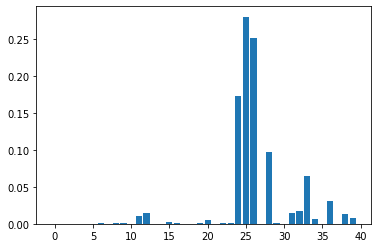

In [24]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Vemos los nombres de las variables que aportan mas al modelo.

In [25]:
dataset_2 = pd.DataFrame({'importance': importance, 'col_name': names}).sort_values(by='importance',ascending=False)
dataset_3 = dataset_2[dataset_2['importance']>=0.07]
dataset_3['importance'] = pd.Series(["{0:.0f}%".format(val * 100) for val in dataset_3['importance']], index = dataset_3.index)
dataset_3

C:\Users\diego172\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,importance,col_name
25,28%,FALSA ALARMA
26,25%,DELITO
24,17%,URGENCIAS MEDICAS
28,10%,CÁMARA


In [55]:
import scipy.sparse

In [67]:
df=pd.DataFrame.sparse.from_spmatrix(c5_input_vars)
df.columns=names
df['y']=c5_inputs.label.values.reshape(c5_input_vars.shape[0],)

In [84]:
selection=list(dataset_3.col_name.values)
selection.append('y')

In [86]:
path = 'output/variables_df.pkl'
utils.save_df(df[selection], path)


## Borrar desde Aquí

In [123]:
def load_features(path):
     return utils.load_df(path)

In [124]:
def save_models(df):
    #os.chdir('../')
    path = 'output/model_loop.pkl'
    utils.save_df(df, path)

In [125]:
def magic_loop(algorithms, df):
    
    y = df['y']
    X = df.drop('y', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    features = X_train
    labels = y_train
    
    estimators_dict = {'tree': DecisionTreeClassifier(random_state=123),
                  'random_forest': RandomForestClassifier(oob_score=True, random_state=123)}
    
    algorithms_dict = {'tree': 'tree_grid_search',
                  'random_forest': 'rf_grid_search'}
    
    grid_search_dict = {'tree_grid_search': {'max_depth': [1,2,5,None], 
                                         'min_samples_leaf': [2,4]},
                   'rf_grid_search': {'n_estimators': [10,20],  
                                      'max_depth': [1,2,5,None], 
                                      'min_samples_leaf': [2,4]}}
    
    best_estimators = []
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        
        #Time Series cross-validator
        tscv = TimeSeriesSplit(n_splits=8)
        
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [126]:
def modeling(path):
    df = load_features(path)
    algorithms = ['tree','random_forest']
    best = magic_loop(algorithms, df)
    save_models(best)
    

In [ ]:
path = 'output/variables_df.pkl'

In [127]:
modeling(path)

C:\Users\diego172\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\diego172\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
